In [1]:
import random

# Step 1: Define functions and terminals
# Functions
functions = ['add', 'sub', 'mul', 'div']
# Terminals
terminals = ['f(n-1)','f(n-2)', -2, -1, 1, 2]

# Step 2: Generate an initial random population of trees
def generate_random_tree(max_depth,depth):
    if (depth == 0 or random.random() < 0.3) and not max_depth == depth:  
        return random.choice(terminals)
    else:
        func = random.choice(functions)
        return [func, generate_random_tree(max_depth,depth - 1), generate_random_tree(max_depth,depth - 1)]

def generate_initial_population(population_size, max_depth):
    return [generate_random_tree(max_depth, max_depth) for _ in range(population_size)]

def evaluate_program(program,target_sequence):
    fn_1 = 0 #f(0) = 0
    fn_2 = 1 #f(1) = 1
    result = []
    for i in range(len(target_sequence)):  
        if(i != 0 and i != 1): #base case
            r = evaluate_tree(program, fn_1, fn_2)
            result.append(r)
            fn_2 = fn_1
            fn_1 = r

        else: result.append(i)
    return result

                

# Step 3: Calculate fitness
def calculate_fitness(program, target_sequence):
    error = 0
    fn_1 = 0 #f(0) = 0
    fn_2 = 1 #f(1) = 1
    for i, term in enumerate(target_sequence):  
        if(i != 0 and i != 1): #base case
            result = evaluate_tree(program, fn_1, fn_2)
            #division by 0
            if result == -1: return 0
            try: 
                error += abs(result - term)**2
            except:
                #overflow
                return 0
            fn_2 = fn_1
            fn_1 = result
     
    return 1 / (1 + error)

def depth(parent):
    if isinstance(parent,list):
        return 1 + max(depth(parent[1]), depth(parent[2]))
    return 0

# the crossover function allows us
# to randomly exchange subtrees between parents to generate the children. The
# crossover function has been defined as follows to generate the desired subtree ex9
# change randomness. First, the minimum depth between parents ’d’ is calculated.
# Then, a probability (1/’d’) of crossover is generated which will be called each
# time a tree function is iterated over until the crossover is performed or the tree
# reaches terminals. If both children are functions, it randomly (uniform distribution) 
# branches through either of them. Otherwise it branches through the node
# that is a function if there is one.
def crossover(parent1, parent2, crossover_rate):
    if random.random() < crossover_rate:
        child1 = [parent1[0]] + [parent1[1]] + [parent2[2]]
        child2 = [parent2[0]] + [parent2[1]] + [parent1[2]]
        return child1, child2
    else:
        parent1_subtree = parent1
        parent2_subtree = parent2
        if isinstance(parent1[1],list) and isinstance(parent1[2],list):
            if random.random() < 0.5:
                parent1_subtree = parent1[1]
            else:
                parent1_subtree = parent1[2]
        elif isinstance(parent1[1],list): parent1_subtree = parent1[1]
        elif isinstance(parent1[2],list): parent1_subtree = parent1[2]
        else: return parent1[1], parent2[1]
            
        if isinstance(parent2[1],list) and isinstance(parent2[2],list):
            if random.random() < 0.5:
                parent2_subtree = parent2[1]
            else:
                parent2_subtree = parent2[2]
        elif isinstance(parent2[1],list): parent2_subtree = parent2[1]
        elif isinstance(parent2[2],list): parent2_subtree = parent2[2]
        else: return parent1[1], parent2[1]
        
        sol1, sol2 = crossover(parent1_subtree, parent2_subtree,crossover_rate)
        if parent1_subtree == parent1[1]:
            if parent2_subtree == parent2[1]:
                return [parent1[0]] + [sol1] + [parent1[2]], [parent2[0]] + [sol2] + [parent2[2]]
            else: return [parent1[0]] + [sol1] + [parent1[2]], [parent2[0]] +  [parent2[1]] + [sol2] 
        else:
            if parent2_subtree == parent2[1]:
                return [parent1[0]] + [parent1[1]]+ [sol1], [parent2[0]] + [sol2] + [parent2[2]]
            else: return [parent1[0]] + [parent1[1]]+ [sol1], [parent2[0]] +  [parent2[1]] + [sol2] 
            

def mutate(program, mutation_rate):
    if random.random() < mutation_rate:
            if program in terminals:
                return generate_random_tree(2,2)
            else:
                return random.choice(terminals)
    else:
        if program in terminals:
            return program
        return [program[0]] + [mutate(program[1],mutation_rate)] + [(mutate(program[2],mutation_rate))]
    
def mutate_tree(program, mutation_rate):
    return [program[0]] + [mutate(program[1],mutation_rate)] + [(mutate(program[2],mutation_rate))]
    
# Helper function to evaluate the tree
def evaluate_tree(tree, fn_1, fn_2):    
    if tree in terminals:
        if tree == 'f(n-1)':
            return fn_1
        elif tree == 'f(n-2)':
            return fn_2
        else:
            return tree
    else:
        operation = tree[0]
        if operation == 'add':
            return evaluate_tree(tree[1], fn_1, fn_2) + evaluate_tree(tree[2], fn_1, fn_2)
        elif operation == 'sub':
            return evaluate_tree(tree[1], fn_1, fn_2) - evaluate_tree(tree[2], fn_1, fn_2)
        elif operation == 'mul':
            return evaluate_tree(tree[1], fn_1, fn_2) * evaluate_tree(tree[2], fn_1, fn_2)
        elif operation == 'div':
            try:
                return evaluate_tree(tree[1], fn_1, fn_2) / evaluate_tree(tree[2], fn_1, fn_2)
            except ZeroDivisionError:
                return -1  
        
        
def solution_found(fitness_values, target_sequence):
    relative_error = []
    for x, y in zip(target_sequence, fitness_values):
        if x == 0 and y == 0:
            relative_error.append(0)  
        else:
            relative_error.append(abs(y - x) / x)

    if all(element <= 0.1 for element in relative_error):
        return True
    return False

# Main GP loop
def genetic_programming(target_sequence):
    #constants
    POPULATION_SIZE=100
    MAX_DEPTH=5
    MUTATION_RATE=0.01
    GENERATIONS=5000

    population = generate_initial_population(POPULATION_SIZE, MAX_DEPTH)

    for it in range(GENERATIONS):
        fitness_values = [calculate_fitness(program, target_sequence) for program in population]
        best_program = population[fitness_values.index(max(fitness_values))]
        evaluation = evaluate_program(best_program,target_sequence)
        sol_found = solution_found(evaluation,target_sequence)
        if sol_found: return best_program,evaluation,it

        sum_fitness_scores = sum(fitness_values)
        selection_prob = [fitness_val / sum_fitness_scores for fitness_val in fitness_values]

        new_population = []
        for _ in range(int(POPULATION_SIZE/2)):
            if sum_fitness_scores != 0: 
                [index1, index2] = random.choices(range(len(population)), weights=selection_prob, k = 2)
            else: 
                [index1, index2] = random.choices(range(len(population)),k = 2)

            child1, child2 = crossover(population[index1], population[index2], 1/min(depth(population[index1]), depth(population[index2])))
            new_population.append(mutate_tree(child1,MUTATION_RATE))
            new_population.append(mutate_tree(child2,MUTATION_RATE))
            
        population = new_population

    best_program = population[fitness_values.index(max(fitness_values))]
    return best_program,evaluate_program(best_program,target_sequence),it



SAMPLE = 5
N_JCOBSTHAL_NUMBERS = 18
target_sequence = []
# Example usage for Jacobsthal numbers
for i in range(N_JCOBSTHAL_NUMBERS):
    if i == 0: target_sequence.append(0)
    elif i == 1: target_sequence.append(1)
    else: target_sequence.append(target_sequence[i-1]+(2*target_sequence[i-2]))

sum_res = [0] * len(target_sequence)
total_it = 0
for it in range(SAMPLE):
    best_program,res,it = genetic_programming(target_sequence)
    sum_res = [x + y for x, y in zip(sum_res, res)]
    total_it += it
    print("Best program:", best_program)
    print("Result: ",res)
    print("Generations: ", it)
    # Calculate relative error, handling the case when y is 0
    relative_error = []
    for x, y in zip(target_sequence, res):
        if y == 0:
            relative_error.append(0)  # Handle the case when y is 0
        else:
            relative_error.append(abs(x - y) / y)
    print("Relative error: ", relative_error)
    

print("--------------------------")
avg_pred = [r/SAMPLE for r in sum_res]
print("Average prediction: ", avg_pred)
print("Average generations: ", total_it/SAMPLE)
# Calculate average relative error, handling the case when y is 0
avg_relative_error = []
for x, y in zip(target_sequence, avg_pred):
    if y == 0:
        avg_relative_error.append(0)  # Handle the case when y is 0
    else:
        avg_relative_error.append(abs(x - y) / y)
print("Average relative error: ", avg_relative_error)

Best program: ['div', -1, ['div', -2, ['mul', ['add', ['sub', 1, ['div', 'f(n-2)', 'f(n-2)']], ['add', ['add', 'f(n-2)', ['div', 2, ['div', 2, 'f(n-1)']]], 'f(n-2)']], 2]]]
Result:  [0, 1, 1.0, 3.0, 5.0, 11.0, 21.0, 43.0, 85.0, 171.0, 341.0, 683.0, 1365.0, 2731.0, 5461.0, 10923.0, 21845.0, 43691.0]
Generations:  1491
Relative error:  [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best program: ['add', ['add', ['add', 'f(n-1)', ['div', 'f(n-1)', 'f(n-1)']], 'f(n-2)'], 'f(n-2)']
Result:  [0, 1, 1, 2.0, 5.0, 10.0, 21.0, 42.0, 85.0, 170.0, 341.0, 682.0, 1365.0, 2730.0, 5461.0, 10922.0, 21845.0, 43690.0]
Generations:  4999
Relative error:  [0, 0.0, 0.0, 0.5, 0.0, 0.1, 0.0, 0.023809523809523808, 0.0, 0.0058823529411764705, 0.0, 0.001466275659824047, 0.0, 0.0003663003663003663, 0.0, 9.155832265152902e-05, 0.0, 2.2888532845044633e-05]
Best program: ['sub', ['mul', ['div', ['sub', ['div', ['sub', ['div', 1, 2], ['sub', -1, 'f(n-1)']], ['mul', ['add', ['

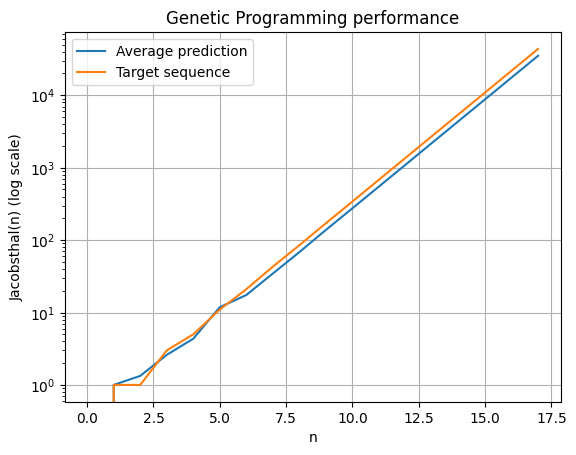

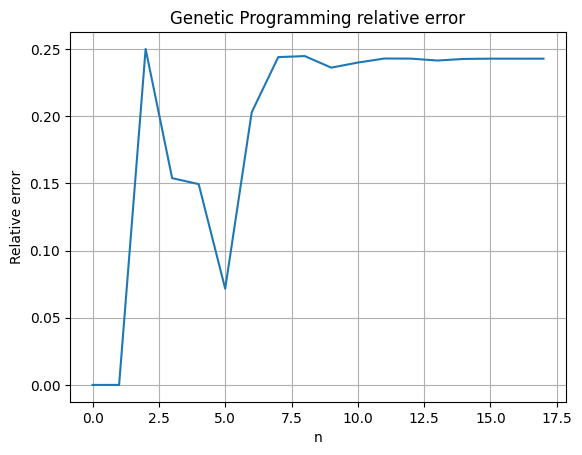

In [10]:
import matplotlib.pyplot as plt
size = range(len(avg_pred))
plt.plot(size, avg_pred, label = "Average prediction")
plt.plot(size, target_sequence, label = "Target sequence")
plt.title(f'Genetic Programming performance')
plt.xlabel('n')
plt.ylabel('Jacobsthal(n) (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(size, avg_relative_error)
plt.title(f'Genetic Programming relative error')
plt.xlabel('n')
plt.ylabel('Relative error')
plt.grid(True)
plt.show()
